# The scientific challenge of the 6th International Conference on Biomedical and Health Informatics (ICBHI2024)

In [1]:
# imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from scipy.interpolate import CubicSpline
from scipy.ndimage import rotate
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from google.colab import drive

In [2]:
# set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)

In [3]:
# mount google drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ICBHI2024')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# augmentation functions
def add_noise(data, noise_factor=0.5):
    noise = np.random.randn(*data.shape) * noise_factor
    return data + noise

def scale_data(data, scale_factor=1.2):
    return data * scale_factor

def time_warp(data, sigma=0.2):
    if len(data.shape) != 3:
        raise ValueError("Data shape is not compatible for time warping.")
    warped_data = np.zeros_like(data)
    for trial in range(data.shape[0]):
        for region in range(data.shape[1]):
            orig_steps = np.arange(data.shape[2])
            random_warp = np.random.normal(loc=1.0, scale=sigma, size=data.shape[2])
            warp_steps = np.cumsum(random_warp) / np.sum(random_warp) * (data.shape[2] - 1)
            cs = CubicSpline(orig_steps, data[trial, region, :])
            warped_data[trial, region, :] = cs(warp_steps)
    return warped_data

def jitter(data, sigma=0.05):
    return data + np.random.normal(loc=0.0, scale=sigma, size=data.shape)

# Function to augment data
def augment_data(data, labels):
    augmented_data = []
    augmented_labels = []
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)

        augmented_data.append(add_noise(sample))
        augmented_labels.append(label)

        augmented_data.append(scale_data(sample))
        augmented_labels.append(label)

        augmented_data.append(time_warp(sample[np.newaxis, ...]).squeeze(0))
        augmented_labels.append(label)

        augmented_data.append(jitter(sample))
        augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

# function to load data from npz files
def load_npz_data(fpath):
    all_data = np.load(fpath)
    return all_data['data']

# function to load brain region names from a file
def load_brain_regions(atlas_path):
    brain_regions = {}
    with open(atlas_path, 'r') as file:
        lines = file.readlines()[1:]  # Skip the header line
        for line in lines:
            index, region = line.strip().split('\t')
            brain_regions[int(index)] = region
    return brain_regions

# function to slice fMRI data into baseline, video, and rating segments
def slice_fMRI_data(data):
    baseline = data[:, 0:5]  # first 5 seconds of the fixation cross
    video = data[:, 5:20]    # 15 seconds of the video
    rating = data[:, 20:25]  # last 5 seconds after the end of the video
    return baseline, video, rating

# function to extract features from fMRI data
def extract_fmri_features(fmri_data, brain_regions):
    features = []
    for trial in range(fmri_data.shape[0]):  # iterate through each trial
        _, video_data, _ = slice_fMRI_data(fmri_data[trial])

        trial_features = []
        for region in range(len(brain_regions)):  # iterate through each region
            var_video = np.var(video_data[region])

            region_features = [
                var_video
            ]
            trial_features.extend(region_features)
        features.append(trial_features)
    return np.array(features)

# function to load participant data
def load_participants_data(data_dir, brain_regions, augment_data_flag=False, labels_present=True):
    subjects = sorted([s for s in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, s))])
    all_fmri_data = []
    all_labels = []
    subject_names = []

    print(f"Loading data from {data_dir}...")
    for subject in tqdm(subjects):
        if subject.startswith('.'):
            continue  # skip hidden files like .DS_Store

        subject_path = os.path.join(data_dir, subject)
        fMRI_data_path = os.path.join(subject_path, 'fMRI_data.npz')

        if os.path.exists(fMRI_data_path):
            fMRI_data = load_npz_data(fMRI_data_path)
            print(f"Subject {subject} fMRI data shape: {fMRI_data.shape}")

            all_fmri_data.append(fMRI_data)
        else:
            print(f"Missing data for {subject}")

        if labels_present:
            labels_path = os.path.join(subject_path, 'labels.npz')
            if os.path.exists(labels_path):
                labels = load_npz_data(labels_path)[:, 0].astype(int)  # only take the class label
                print(f"Subject {subject} labels shape: {labels.shape}")
                all_labels.append(labels)
            else:
                print(f"Missing labels for {subject}")

        # track the subject names
        subject_names.append(subject)

    # combine all data and labels from all subjects
    all_fmri_data = np.concatenate(all_fmri_data, axis=0)
    print(f"All fMRI data shape after concatenation: {all_fmri_data.shape}")
    all_labels = np.concatenate(all_labels, axis=0) if labels_present and all_labels else None
    if all_labels is not None:
        print(f"All labels shape after concatenation: {all_labels.shape}")

    if augment_data_flag and all_labels is not None:
        all_fmri_data, all_labels = augment_data(all_fmri_data, all_labels)

    # extract features after augmentation
    all_fmri_features = extract_fmri_features(all_fmri_data, brain_regions)
    print(f"All fMRI features shape after feature extraction: {all_fmri_features.shape}")

    if labels_present and all_labels is not None:
        return {'fmri_features': all_fmri_features, 'labels': all_labels, 'subject_names': subject_names}
    else:
        return {'fmri_features': all_fmri_features, 'subject_names': subject_names}

atlas_path = 'data/Supplementary/BN_atlas.txt'
train_data_dir = 'data/Train'
test_data_dir = 'data/Test'

brain_regions = load_brain_regions(atlas_path)
train_data = load_participants_data(train_data_dir, brain_regions, augment_data_flag=True, labels_present=True)
test_data = load_participants_data(test_data_dir, brain_regions, augment_data_flag=False, labels_present=False)

print(train_data.keys())
print(test_data.keys())
print(train_data['fmri_features'].shape)
print(train_data['labels'].shape)
print(test_data['fmri_features'].shape)


Loading data from data/Train...


 31%|███▏      | 5/16 [00:00<00:00, 42.37it/s]

Subject P01 fMRI data shape: (30, 246, 25)
Subject P01 labels shape: (30,)
Subject P02 fMRI data shape: (30, 246, 25)
Subject P02 labels shape: (30,)
Subject P03 fMRI data shape: (30, 246, 25)
Subject P03 labels shape: (30,)
Subject P04 fMRI data shape: (30, 246, 25)
Subject P04 labels shape: (30,)
Subject P05 fMRI data shape: (30, 246, 25)
Subject P05 labels shape: (30,)
Subject P06 fMRI data shape: (30, 246, 25)
Subject P06 labels shape: (30,)
Subject P07 fMRI data shape: (30, 246, 25)
Subject P07 labels shape: (30,)
Subject P08 fMRI data shape: (30, 246, 25)
Subject P08 labels shape: (30,)
Subject P09 fMRI data shape: (30, 246, 25)
Subject P09 labels shape: (30,)


100%|██████████| 16/16 [00:00<00:00, 43.28it/s]

Subject P10 fMRI data shape: (30, 246, 25)
Subject P10 labels shape: (30,)
Subject P11 fMRI data shape: (30, 246, 25)
Subject P11 labels shape: (30,)
Subject P12 fMRI data shape: (30, 246, 25)
Subject P12 labels shape: (30,)
Subject P13 fMRI data shape: (30, 246, 25)
Subject P13 labels shape: (30,)
Subject P14 fMRI data shape: (30, 246, 25)
Subject P14 labels shape: (30,)
Subject P15 fMRI data shape: (30, 246, 25)
Subject P15 labels shape: (30,)
Subject P16 fMRI data shape: (30, 246, 25)
Subject P16 labels shape: (30,)
All fMRI data shape after concatenation: (480, 246, 25)
All labels shape after concatenation: (480,)


All fMRI features shape after feature extraction: (2400, 246)
Loading data from data/Test...


100%|██████████| 4/4 [00:00<00:00, 51.49it/s]

Subject P17 fMRI data shape: (30, 246, 25)
Subject P18 fMRI data shape: (30, 246, 25)
Subject P19 fMRI data shape: (30, 246, 25)
Subject P20 fMRI data shape: (30, 246, 25)
All fMRI data shape after concatenation: (120, 246, 25)


All fMRI features shape after feature extraction: (120, 246)
dict_keys(['fmri_features', 'labels', 'subject_names'])
dict_keys(['fmri_features', 'subject_names'])
(2400, 246)
(2400,)
(120, 246)


Training on fold 1...
Epoch 1/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3157 - loss: 1.1274 - val_accuracy: 0.4967 - val_loss: 1.0488
Epoch 2/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4536 - loss: 1.0547 - val_accuracy: 0.5550 - val_loss: 1.0112
Epoch 3/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5084 - loss: 1.0164 - val_accuracy: 0.5717 - val_loss: 0.9743
Epoch 4/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5264 - loss: 0.9837 - val_accuracy: 0.6117 - val_loss: 0.9270
Epoch 5/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5859 - loss: 0.9322 - val_accuracy: 0.6533 - val_loss: 0.8881
Epoch 6/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5881 - loss: 0.9074 - val_accuracy: 0.6467 - val_loss: 0.8517
Epoch 7/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6217 - loss: 0.8745 - val_accuracy: 0.6767 - val_loss: 0.8170
Epoch 8/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6350 - loss: 0.8

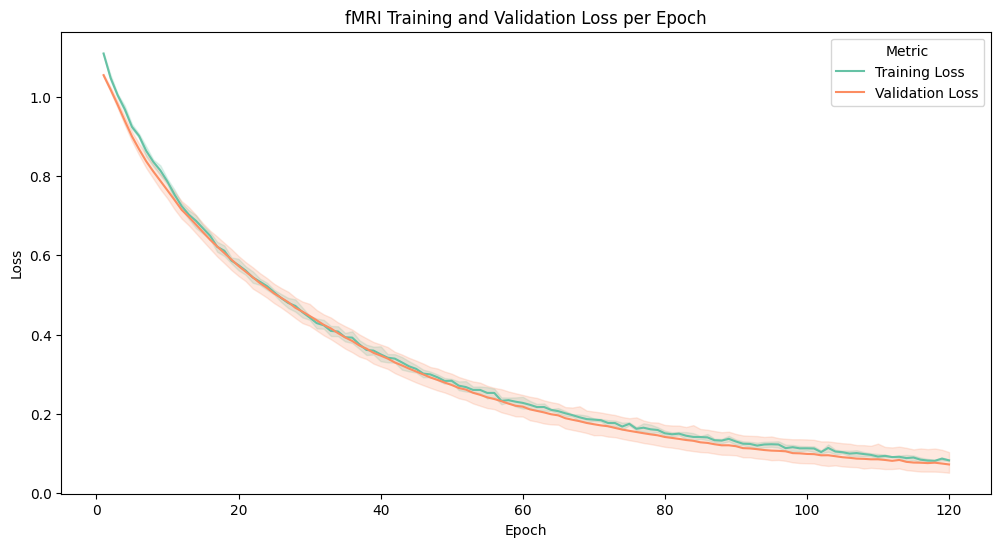

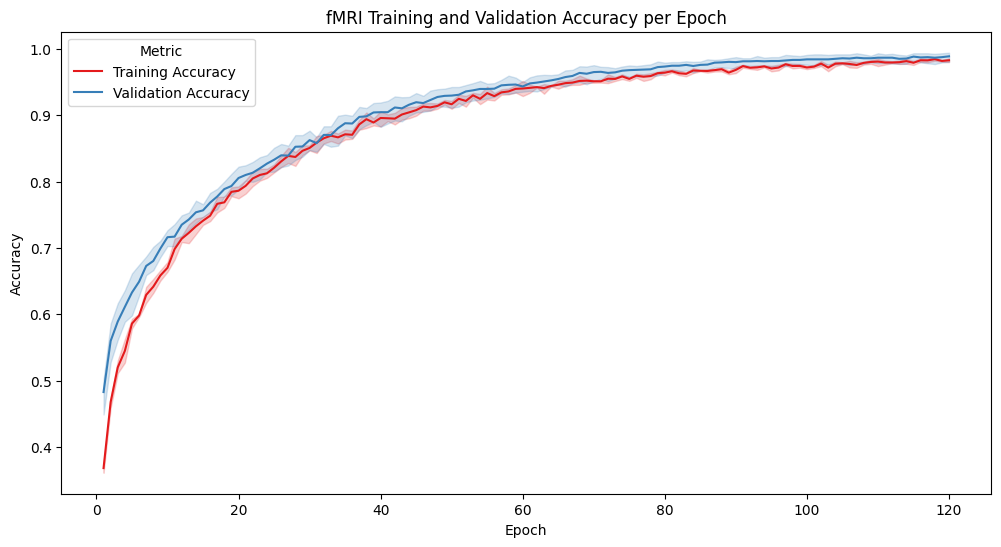

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

First 120 predicted labels for the test data:
[ 0 -1  1  0 -1  1  0 -1 -1  0  1  1 -1 -1  0  0  0  0  1  0  1 -1 -1 -1
 -1 -1  1  0  0 -1  1  1  0  1 -1 -1  0  1  0 -1  0  0  0  1  0 -1  1  1
  0 -1  1  1 -1  0 -1  1  0  0 -1  0  1 -1 -1  0  0  0 -1  1  0 -1 -1  1
  0  0  0 -1  1  0  1  0 -1  0  0  0  1 -1  0 -1  0  0  0 -1  1  1  1  1
  0  1 -1  1  0  0  1  0  0  1  1  1  0 -1  0 -1  1  1 -1  1  1  1 -1  1]


In [5]:
# shuffle the data
train_data['fmri_features'], train_data['labels'] = shuffle(train_data['fmri_features'], train_data['labels'], random_state=42)

# normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data['fmri_features'])
X_test = scaler.transform(test_data['fmri_features'])

# prepare the labels
num_classes = 3
y_train = to_categorical(train_data['labels'], num_classes)

# reshape data for input into Conv1D (add channel dimension)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# define the CNN model
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# stratified K-fold Cross Validation
kf = StratifiedKFold(n_splits=4)

# convert categorical labels back to a 1D array for stratification purposes
y_labels_train = np.argmax(y_train, axis=1)

fold_no = 1
accuracy_per_fold = []
loss_per_fold = []
train_accuracy_per_fold = []
train_loss_per_fold = []

# create a list to store epoch-wise data
epoch_data = []

# training using StratifiedKFold
for train_index, val_index in kf.split(X_train, y_labels_train):
    # split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # create and compile the model
    input_shape = (X_train.shape[1], 1)
    model = create_cnn_model(input_shape, num_classes)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # train the model with early stopping
    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=120,
                        batch_size=128,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping],
                        verbose=1)

    # evaluate the model on the validation set for this fold
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    train_loss, train_accuracy = model.evaluate(X_train_fold, y_train_fold, verbose=0)

    print(f'Fold {fold_no} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # store training and validation metrics for this fold
    accuracy_per_fold.append(val_accuracy)
    loss_per_fold.append(val_loss)
    train_accuracy_per_fold.append(train_accuracy)
    train_loss_per_fold.append(train_loss)

    # gather epoch-wise data for plotting
    for epoch in range(len(history.history['loss'])):
        epoch_data.append({
            'Epoch': epoch + 1,
            'Training Loss': history.history['loss'][epoch],
            'Validation Loss': history.history['val_loss'][epoch],
            'Training Accuracy': history.history['accuracy'][epoch],
            'Validation Accuracy': history.history['val_accuracy'][epoch],
            'Fold': fold_no
        })

    fold_no += 1

# print cross-validation results
print('\nCross-validation results:')
print(f'Average Training Accuracy: {np.mean(train_accuracy_per_fold):.4f} ± {np.std(train_accuracy_per_fold):.4f}')
print(f'Average Training Loss: {np.mean(train_loss_per_fold):.4f} ± {np.std(train_loss_per_fold):.4f}')
print(f'Average Validation Accuracy: {np.mean(accuracy_per_fold):.4f} ± {np.std(accuracy_per_fold):.4f}')
print(f'Average Validation Loss: {np.mean(loss_per_fold):.4f} ± {np.std(loss_per_fold):.4f}')

# convert epoch data to DataFrame
df_epochs = pd.DataFrame(epoch_data)

# plot Training and Validation Loss
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(df_epochs, ['Epoch', 'Fold'], value_vars=['Training Loss', 'Validation Loss']),
             palette='Set2')
plt.title('fMRI Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Metric')
plt.show()

# plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(df_epochs, ['Epoch', 'Fold'], value_vars=['Training Accuracy', 'Validation Accuracy']),
             palette='Set1')
plt.title('fMRI Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Metric')
plt.show()

# making predictions on the test data using the final model (trained on the last fold)
predictions = model.predict(X_test)

# convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# update label 2 to -1
predicted_classes = np.where(predicted_classes == 2, -1, predicted_classes)

# print the first 120 predicted labels
print("\nFirst 120 predicted labels for the test data:")
print(predicted_classes[:120])